In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torch.utils.tensorboard as tb
from Preprocessing.preprocessing_sorted import PreprocessingTrainingData
from torch.utils.data.sampler import SequentialSampler
import seaborn as sns
import matplotlib.pyplot as  plt
import os
import logging
torch.set_printoptions(profile="full")
import pandas as pd

In [2]:
#static parameters
train_batch_size = 30
val_batch_size = 30
sequence_length=50
test_batch_size = 1
input_size = 1
hidden_size = 256
num_layer = 2
output_size = 38
clip = 3

In [84]:
#get data from preprocessing.py
dataset_path = os.path.join(os.path.abspath('..'),'Dataset\\Clementi dataset\\Clementi dataset' )
network_input,network_output,max_midi_number,min_midi_number,int_to_note = PreprocessingTrainingData().preprocess_notes(dataset_path)
network_input, network_output = network_input.cuda(), network_output.cuda()

# print(network_input)
#print(network_output)

In [4]:
print(network_output.max())
print(network_output.min())

tensor(37, device='cuda:0')
tensor(0, device='cuda:0')


In [5]:
#network_output

In [6]:
print(network_input.max())
print(network_input.min())
print(max_midi_number)
print(min_midi_number)
print(int_to_note)

tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
89
50
{0: 50, 1: 52, 2: 53, 3: 54, 4: 55, 5: 56, 6: 57, 7: 58, 8: 59, 9: 60, 10: 61, 11: 62, 12: 63, 13: 64, 14: 65, 15: 66, 16: 67, 17: 68, 18: 69, 19: 70, 20: 71, 21: 72, 22: 73, 23: 74, 24: 75, 25: 76, 26: 77, 27: 78, 28: 79, 29: 80, 30: 81, 31: 82, 32: 83, 33: 84, 34: 85, 35: 86, 36: 88, 37: 89}


C:\Users\utkar\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\utkar\Anaconda3\envs\pytorch_env\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


,values
0,
0,2
1,3
2,7
3,2
4,24
5,3
6,21
7,4
8,39


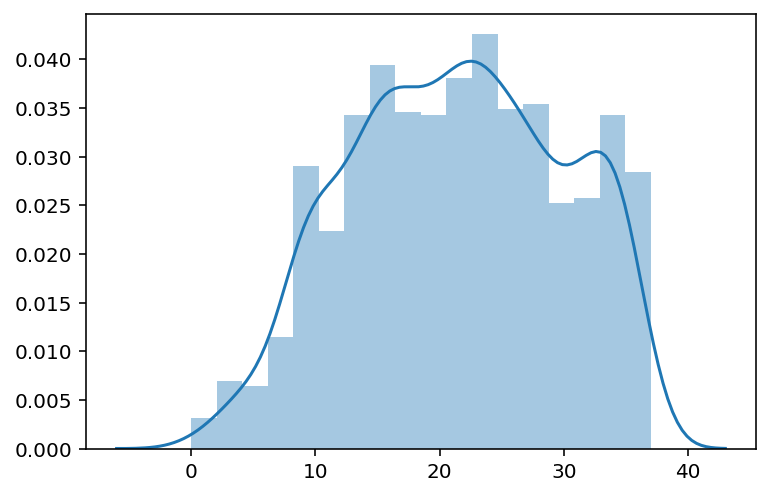

In [7]:
'''
data is highly unbalanced
# '''
sns.distplot(torch.tensor(network_output).cpu())
xx = pd.DataFrame(torch.tensor(network_output).cpu())
xx.groupby(0).size().to_frame(name='values')

In [8]:
'''
to make batch of equal sizes
Quick Fix
'''
network_input = network_input[: -29]
network_output = network_output[: -29]

print(network_input.shape)
print(network_output.shape)

torch.Size([1800, 50, 1])
torch.Size([1800])


In [9]:
#network_input[0]

In [23]:
'''
create Stacked LSTM model
'''
class Stacked_LSTM(nn.Module):
    def __init__(self,input_size, hidden_size, num_layers, output_size):
        super().__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size

        self.lstm1 = nn.LSTM(input_size = input_size, hidden_size = hidden_size, batch_first = True)
        self.lstm2 = nn.LSTM(input_size = hidden_size, hidden_size = output_size,batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(output_size, output_size)
        
        
    def forward(self, x, hidden1, hidden2,batch_size):
        
        output, _ = self.lstm1(x)        
        #print(output.shape)
        
        #output = self.dropout(output)
        
        output, _ = self.lstm2(output)
        #print(output.shape)
        
        # stack up lstm outputs
        output = output.contiguous().view(-1, 38)
        #print(output.shape)
        
        output = self.dropout(output)
        output = self.linear(output)
        #print('Linear Output :-',output.shape)
        
        #output = F.softmax(output, dim = 1)
        #print('SOFTMAX OUTPUT :--', output)
        
        
        # reshape to be batch_size first
        output = output.view(batch_size, -1)
        #print('Reshape to batch size first :-',output.shape)
        
        output = output[:, -self.output_size:] # get last batch of labels
        #print('Final Output :-',output)
        #print('RESHAPE SIZE :-', output.shape)
        
        return output, hidden2
    
    def hidden_init(self,batch_size):
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(1, batch_size, self.hidden_size).zero_().cuda(),
          weight.new(1, batch_size, self.hidden_size).zero_().cuda())
        
        hidden2 = (weight.new(1, batch_size, 38).zero_().cuda(),
          weight.new(1, batch_size, 38).zero_().cuda())
        return hidden1,hidden2

#initialize the weights of LSTM using Xavier initialization    
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

    

In [24]:
'''
Divide the dataset into train/val 
'''
train_size = 0.8
indices = list(range(len(network_input)))
split = int(np.floor(train_size*len(network_input)))
train_idx, val_idx = indices[:split], indices[split:]

train_sampler = SequentialSampler(train_idx)
val_sampler = SequentialSampler(val_idx)

dataset = TensorDataset(network_input,network_output)
train_loader = DataLoader(dataset, batch_size= train_batch_size, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size= val_batch_size,sampler= val_sampler)

In [25]:
import torch.optim as optimizer

model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
model.apply(init_weights)

criterion = nn.CrossEntropyLoss()
optimizer = optimizer.AdamW(model.parameters())
#optimizer = optimizer.RMSprop(model.parameters(), lr = 0.001, weight_decay = 0.01)


#make sure to transfer model to GPU after initializing optimizer
model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [26]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0.01
)

In [27]:
#hidden = model.hidden_init(train_batch_size) 
#hidden

In [28]:
epochs = 300
min_val_loss = np.Inf

for e in range(epochs):
    
    train_loss = 0
    val_loss = 0
    train_accuracy = 0
    val_accuracy = 0
    
    
    hidden1, hidden2 = model.hidden_init(train_batch_size)    
    #print('hidden[0].shape:- ',hidden[0].shape)
    
    for inputs,labels in train_loader:
        #print(inputs.shape)

        '''
        Creating new variables for the hidden state, otherwise
        we'd backprop through the entire training history
        '''
        #h = tuple([each.data for each in hidden])
        
        h1 = tuple([each.data for each in hidden1])
        h2 = tuple([each.data for each in hidden2])
        
        # zero accumulated gradients
        model.zero_grad()
       
        # get the output from the model
        output, _ = model.forward(inputs, h1, h2, train_batch_size)
        #print('OUTPUT', output)
        
        
        #print('Labels Shape :-', (torch.max(labels, 1)[1]).shape)
    
        # calculate the loss and perform backprop
        #print('Labels Long :-', labels.long())
        loss = criterion(output,labels.long())
        #print('LOSS IS :-', loss)
        
        loss.backward()
        
        #calculate training accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        logging.debug(' top probab {} top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        equals = top_class == labels.long().view(*top_class.shape)
        train_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        #nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        train_loss += loss.item()
        #print(train_loss)
              
    model.eval()
    for inputs, labels in val_loader:
                
        val_h1 = tuple([each.data for each in hidden1])
        val_h2 = tuple([each.data for each in hidden2])
        
        output, _ = model.forward(inputs, val_h1, val_h2,val_batch_size)
       
        loss = criterion(output,labels.long())
        
        val_loss += loss.item()
        
        #calculate validation accuracy
        output = F.softmax(output, dim = 1)
        top_p, top_class = output.topk(1, dim=1)
        
        #logging.debug(output)
        #logging.debug('VALIDATION top probab {} VALIDATION top class {}'.format(top_p.view(-1, top_p.shape[0]), top_class.view(-1, top_p.shape[0])))

        #print('Top Class:- ',top_class)
        equals = top_class == labels.long().view(*top_class.shape)
        #print('Equals:- ', equals)
        val_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
    model.train()
    
    #Averaging losses
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    val_accuracy = val_accuracy/len(val_loader)
    train_accuracy = train_accuracy/len(train_loader)
    
    print('Epoch: {}\tTrain Loss: {:.7f} \tVal Loss:{:.7f} \tTrain Acc: {:.7}% \tVal Acc: {:.7f}%'.format(e, train_loss, val_loss, train_accuracy*100,val_accuracy*100))
    
    #saving the model if validation loss is decreased
    if val_loss <= min_val_loss:
        print('Validation Loss decreased from {:6f} to {:6f}, saving the model weights'.format(min_val_loss, val_loss))
        torch.save(model.state_dict(), 'lstm_state_256_different_layers_testing.pt')
        min_val_loss = val_loss

Epoch: 0	Train Loss: 3.6143509 	Val Loss:3.4416847 	Train Acc: 5.138889% 	Val Acc: 1.6666667%
Validation Loss decreased from    inf to 3.441685, saving the model weights
Epoch: 1	Train Loss: 3.4694550 	Val Loss:3.2468535 	Train Acc: 3.888889% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.441685 to 3.246853, saving the model weights
Epoch: 2	Train Loss: 3.3951238 	Val Loss:3.1991594 	Train Acc: 4.375% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.246853 to 3.199159, saving the model weights
Epoch: 3	Train Loss: 3.3731747 	Val Loss:3.1783147 	Train Acc: 4.305556% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.199159 to 3.178315, saving the model weights
Epoch: 4	Train Loss: 3.3763277 	Val Loss:3.1706097 	Train Acc: 3.888889% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.178315 to 3.170610, saving the model weights
Epoch: 5	Train Loss: 3.3491620 	Val Loss:3.1630059 	Train Acc: 5.069445% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.170610 to 3.163006

Epoch: 71	Train Loss: 3.2879359 	Val Loss:3.1253720 	Train Acc: 6.180556% 	Val Acc: 8.8888892%
Epoch: 72	Train Loss: 3.2813236 	Val Loss:3.1255335 	Train Acc: 6.25% 	Val Acc: 8.8888892%
Epoch: 73	Train Loss: 3.2725217 	Val Loss:3.1248193 	Train Acc: 6.319445% 	Val Acc: 8.8888892%
Epoch: 74	Train Loss: 3.2854690 	Val Loss:3.1251980 	Train Acc: 6.180556% 	Val Acc: 8.8888892%
Epoch: 75	Train Loss: 3.2830946 	Val Loss:3.1224301 	Train Acc: 6.458334% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.122627 to 3.122430, saving the model weights
Epoch: 76	Train Loss: 3.2773635 	Val Loss:3.1190680 	Train Acc: 6.388889% 	Val Acc: 8.8888892%
Validation Loss decreased from 3.122430 to 3.119068, saving the model weights
Epoch: 77	Train Loss: 3.2785499 	Val Loss:3.1194446 	Train Acc: 5.347222% 	Val Acc: 8.8888892%
Epoch: 78	Train Loss: 3.2780623 	Val Loss:3.1231628 	Train Acc: 5.763889% 	Val Acc: 8.8888892%
Epoch: 79	Train Loss: 3.2888508 	Val Loss:3.1300820 	Train Acc: 5.277778% 	Val Acc: 8.88

Epoch: 130	Train Loss: 2.4765742 	Val Loss:2.3043671 	Train Acc: 20.97222% 	Val Acc: 30.0000006%
Validation Loss decreased from 2.329481 to 2.304367, saving the model weights
Epoch: 131	Train Loss: 2.4818330 	Val Loss:2.2993408 	Train Acc: 20.90278% 	Val Acc: 30.8333340%
Validation Loss decreased from 2.304367 to 2.299341, saving the model weights
Epoch: 132	Train Loss: 2.4773996 	Val Loss:2.2845073 	Train Acc: 22.22222% 	Val Acc: 30.5555561%
Validation Loss decreased from 2.299341 to 2.284507, saving the model weights
Epoch: 133	Train Loss: 2.4727651 	Val Loss:2.2887275 	Train Acc: 21.80556% 	Val Acc: 28.3333340%
Epoch: 134	Train Loss: 2.4624721 	Val Loss:2.2612871 	Train Acc: 20.97222% 	Val Acc: 31.1111119%
Validation Loss decreased from 2.284507 to 2.261287, saving the model weights
Epoch: 135	Train Loss: 2.4498557 	Val Loss:2.2748694 	Train Acc: 20.97222% 	Val Acc: 28.0555564%
Epoch: 136	Train Loss: 2.4387848 	Val Loss:2.2554212 	Train Acc: 21.80556% 	Val Acc: 30.0000004%
Validatio

Epoch: 189	Train Loss: 1.6447510 	Val Loss:1.3280080 	Train Acc: 48.47222% 	Val Acc: 61.3888895%
Validation Loss decreased from 1.377824 to 1.328008, saving the model weights
Epoch: 190	Train Loss: 1.6545445 	Val Loss:1.3394639 	Train Acc: 48.33333% 	Val Acc: 60.8333339%
Epoch: 191	Train Loss: 1.6971866 	Val Loss:1.4040742 	Train Acc: 45.90278% 	Val Acc: 61.3888890%
Epoch: 192	Train Loss: 1.6254618 	Val Loss:1.3648066 	Train Acc: 49.93056% 	Val Acc: 61.9444445%
Epoch: 193	Train Loss: 1.6197715 	Val Loss:1.3282588 	Train Acc: 49.93056% 	Val Acc: 63.0555563%
Epoch: 194	Train Loss: 1.6122060 	Val Loss:1.3453226 	Train Acc: 48.95833% 	Val Acc: 60.0000006%
Epoch: 195	Train Loss: 1.5585985 	Val Loss:1.2491114 	Train Acc: 51.45833% 	Val Acc: 66.9444447%
Validation Loss decreased from 1.328008 to 1.249111, saving the model weights
Epoch: 196	Train Loss: 1.5640857 	Val Loss:1.2251620 	Train Acc: 49.51389% 	Val Acc: 66.9444447%
Validation Loss decreased from 1.249111 to 1.225162, saving the mode

Epoch: 253	Train Loss: 0.5879756 	Val Loss:0.3056395 	Train Acc: 84.23611% 	Val Acc: 95.2777763%
Epoch: 254	Train Loss: 0.5880724 	Val Loss:0.3265296 	Train Acc: 84.02778% 	Val Acc: 93.6111103%
Epoch: 255	Train Loss: 0.5579972 	Val Loss:0.3177722 	Train Acc: 85.625% 	Val Acc: 94.1666663%
Epoch: 256	Train Loss: 0.5486068 	Val Loss:0.2771095 	Train Acc: 85.55555% 	Val Acc: 95.8333328%
Validation Loss decreased from 0.296075 to 0.277109, saving the model weights
Epoch: 257	Train Loss: 0.4869845 	Val Loss:0.2550021 	Train Acc: 87.22222% 	Val Acc: 95.5555553%
Validation Loss decreased from 0.277109 to 0.255002, saving the model weights
Epoch: 258	Train Loss: 0.4644327 	Val Loss:0.2371458 	Train Acc: 87.77778% 	Val Acc: 96.9444439%
Validation Loss decreased from 0.255002 to 0.237146, saving the model weights
Epoch: 259	Train Loss: 0.4678676 	Val Loss:0.2609410 	Train Acc: 88.61111% 	Val Acc: 95.5555543%
Epoch: 260	Train Loss: 0.5134612 	Val Loss:0.3001234 	Train Acc: 86.31944% 	Val Acc: 93.0

## MUSIC GENERATION

In [94]:
#load weights
test_model = Stacked_LSTM(input_size,hidden_size,num_layer,output_size)
test_model.load_state_dict(torch.load('lstm_state_256_different_layers_testing.pt'))
test_model.eval()
test_model.cuda()

Stacked_LSTM(
  (lstm1): LSTM(1, 256, batch_first=True)
  (lstm2): LSTM(256, 38, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=38, out_features=38, bias=True)
)

In [135]:
#load population database
#testing_data = np.ones(200)*0.59
testing_data = list(range(50,90))
#testing_data.extend(testing_data[::-1])
testing_data_rev = testing_data[::-1]
testing_data_rev.extend(testing_data)
testing_data = testing_data_rev


testing_data = np.asarray(testing_data)
testing_data = testing_data.reshape(testing_data.shape[0],1)

initial_seq = [network_input[0][1:].cpu().numpy().tolist()]

abc = testing_data


In [137]:
#abc

In [138]:
list1=[]
testing_data=testing_data.tolist()
for i in range(len(testing_data)):
    list1.extend(testing_data[i])

#list1

for i in range(len(list1)):
    list1[i]=(list1[i]-50)/(89-50)

list1 = np.asarray(list1)
list1 = list1.reshape(list1.shape[0],1)
testing_data = list1
#list1

In [142]:
#testing_data

In [143]:
#testing_data

In [144]:
#Predicting
def prediction_with_influence(influence,int2note,initial_seq, max_note, test_batch_size = 1):

    predicted_notes = []
    initial_seq[0].extend([[0]]*len(testing_data))
    test_seq = torch.Tensor(initial_seq).cuda()
    
    h1, h2 = test_model.hidden_init(test_batch_size)

    
    for i in range(len(influence)):
        
        test_seq[0][sequence_length - 1 + i][0] = float(influence[i])
        
        test_slice = test_seq[0][i : i + sequence_length]        
        test_slice = test_slice.view(1, test_slice.shape[0], test_slice.shape[1])
                
        test_hidden1 = tuple([each.data for each in h1])
        test_hidden2 = tuple([each.data for each in h2])
        
        test_output,_ = test_model.forward(test_slice, test_hidden1, test_hidden2, test_batch_size)
    
        test_output = F.softmax(test_output, dim = 1)
        top_p, top_class = test_output.topk(1,dim =1)
        test_seq[0][sequence_length - 1 + i][0] = int2note[top_class.item()]/max_note
        
        predicted_notes.append(int2note[top_class.item()])
        
    return predicted_notes

In [145]:
predicted_notes_lst = prediction_with_influence(testing_data,int_to_note,initial_seq, max_midi_number)

In [146]:
#predicted_notes_lst

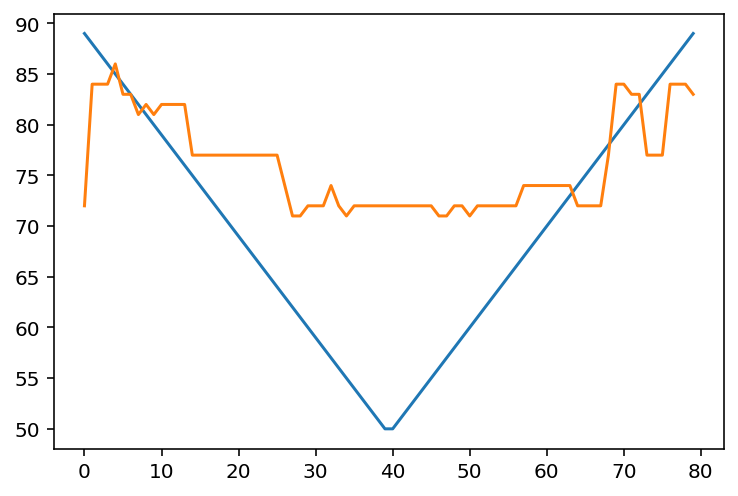

In [147]:
import seaborn as sns
import matplotlib.pyplot as plt

#plt.plot(list(np.ones(200)*73))
#plt.plot(list(np.ones(200)*50))
plt.plot(abc)
plt.plot(predicted_notes_lst)

In [103]:
from collections import Counter
c = Counter(predicted_notes_lst)
c

Counter({72: 16, 74: 18, 81: 6, 78: 2, 83: 2, 82: 2, 77: 154})

In [65]:
a = []
network_input=(network_input)
for b in range(len(network_input)):
    for k in range(len(network_input[b])):
        a.extend(network_input[b][k])
#a.extend(x for x in network_input)

In [67]:

from collections import Counter
c = Counter(a)
c

Counter({0.5641025900840759: 7564,
         0.6666666865348816: 6933,
         0.43589743971824646: 7349,
         0.7435897588729858: 6115,
         0.692307710647583: 3584,
         0.6153846383094788: 9868,
         0.5384615659713745: 6991,
         0.4871794879436493: 6603,
         0.41025641560554504: 2486,
         0.7179487347602844: 3048,
         0.7948718070983887: 3958,
         0.8461538553237915: 2216,
         0.8717948794364929: 1474,
         0.9230769276618958: 1804,
         0.6410256624221802: 941,
         0.25641027092933655: 2032,
         0.3589743673801422: 3808,
         0.12820513546466827: 518,
         0.38461539149284363: 2833,
         0.3076923191547394: 2965,
         0.23076923191547394: 745,
         0.1794871836900711: 205,
         0.5128205418586731: 994,
         0.3333333432674408: 195,
         0.5897436141967773: 2137,
         0.8974359035491943: 492,
         0.07692307978868484: 55,
         0.4615384638309479: 626,
         0.2820512950420

In [71]:
plt.plot(a*(89-50)+50)

TypeError: can only concatenate list (not "int") to list

In [73]:
a=[(i*(89-50)+50) for i in a ]

In [78]:
import math
a=[math.floor(i) for i in a]
a

[72,
 76,
 72,
 67,
 72,
 76,
 72,
 67,
 79,
 77,
 76,
 74,
 72,
 71,
 72,
 71,
 72,
 74,
 72,
 71,
 69,
 67,
 72,
 76,
 72,
 67,
 76,
 79,
 76,
 72,
 76,
 72,
 74,
 71,
 72,
 69,
 71,
 67,
 69,
 66,
 67,
 69,
 71,
 72,
 74,
 76,
 78,
 79,
 69,
 81,
 76,
 72,
 67,
 72,
 76,
 72,
 67,
 79,
 77,
 76,
 74,
 72,
 71,
 72,
 71,
 72,
 74,
 72,
 71,
 69,
 67,
 72,
 76,
 72,
 67,
 76,
 79,
 76,
 72,
 76,
 72,
 74,
 71,
 72,
 69,
 71,
 67,
 69,
 66,
 67,
 69,
 71,
 72,
 74,
 76,
 78,
 79,
 69,
 81,
 71,
 72,
 67,
 72,
 76,
 72,
 67,
 79,
 77,
 76,
 74,
 72,
 71,
 72,
 71,
 72,
 74,
 72,
 71,
 69,
 67,
 72,
 76,
 72,
 67,
 76,
 79,
 76,
 72,
 76,
 72,
 74,
 71,
 72,
 69,
 71,
 67,
 69,
 66,
 67,
 69,
 71,
 72,
 74,
 76,
 78,
 79,
 69,
 81,
 71,
 72,
 67,
 72,
 76,
 72,
 67,
 79,
 77,
 76,
 74,
 72,
 71,
 72,
 71,
 72,
 74,
 72,
 71,
 69,
 67,
 72,
 76,
 72,
 67,
 76,
 79,
 76,
 72,
 76,
 72,
 74,
 71,
 72,
 69,
 71,
 67,
 69,
 66,
 67,
 69,
 71,
 72,
 74,
 76,
 78,
 79,
 69,
 81,
 71,
 72,
 74,


In [80]:
c = Counter(a)
c

Counter({72: 7564,
         76: 6933,
         67: 7349,
         79: 6115,
         77: 3584,
         74: 9868,
         71: 6991,
         69: 6603,
         66: 2486,
         78: 3048,
         81: 3958,
         83: 2216,
         84: 1474,
         86: 1804,
         75: 941,
         60: 2032,
         64: 3808,
         55: 518,
         65: 2833,
         62: 2965,
         59: 745,
         57: 205,
         70: 994,
         63: 195,
         73: 2137,
         85: 492,
         53: 55,
         68: 626,
         61: 232,
         80: 223,
         89: 136,
         88: 592,
         52: 12,
         82: 216,
         58: 24,
         50: 9,
         54: 13,
         56: 4})

In [85]:
network_output=network_output.cpu().numpy().tolist()

In [86]:
network_output

[20,
 21,
 23,
 25,
 27,
 28,
 30,
 32,
 21,
 33,
 23,
 28,
 32,
 35,
 33,
 32,
 30,
 28,
 27,
 25,
 28,
 27,
 30,
 28,
 27,
 25,
 23,
 21,
 20,
 23,
 21,
 20,
 18,
 16,
 21,
 25,
 21,
 16,
 21,
 25,
 21,
 16,
 28,
 26,
 25,
 23,
 21,
 20,
 21,
 20,
 21,
 23,
 21,
 20,
 18,
 16,
 21,
 25,
 21,
 16,
 25,
 28,
 25,
 21,
 25,
 21,
 23,
 20,
 21,
 18,
 20,
 16,
 18,
 15,
 16,
 18,
 20,
 21,
 23,
 25,
 27,
 28,
 18,
 30,
 20,
 21,
 23,
 25,
 27,
 28,
 30,
 32,
 21,
 33,
 23,
 28,
 32,
 35,
 33,
 32,
 30,
 28,
 27,
 25,
 28,
 27,
 30,
 28,
 27,
 25,
 23,
 21,
 20,
 23,
 21,
 20,
 18,
 16,
 20,
 23,
 20,
 16,
 21,
 24,
 21,
 16,
 28,
 26,
 23,
 24,
 21,
 20,
 21,
 23,
 20,
 16,
 28,
 16,
 28,
 16,
 28,
 16,
 28,
 16,
 28,
 16,
 28,
 16,
 28,
 16,
 28,
 16,
 23,
 24,
 26,
 23,
 26,
 24,
 23,
 21,
 20,
 9,
 13,
 9,
 4,
 9,
 13,
 9,
 4,
 16,
 14,
 13,
 11,
 9,
 8,
 9,
 8,
 9,
 11,
 9,
 8,
 6,
 4,
 9,
 4,
 9,
 13,
 9,
 13,
 16,
 21,
 16,
 11,
 13,
 8,
 9,
 11,
 13,
 14,
 16,
 18,
 20,
 21,
 11,
 

In [87]:
c = Counter(network_output)
c

Counter({20: 65,
         21: 78,
         23: 95,
         25: 67,
         27: 65,
         28: 68,
         30: 65,
         32: 65,
         33: 65,
         35: 65,
         18: 65,
         16: 83,
         26: 64,
         15: 65,
         24: 65,
         9: 64,
         13: 65,
         4: 24,
         14: 64,
         11: 65,
         8: 39,
         6: 21,
         19: 64,
         12: 19,
         22: 65,
         34: 64,
         2: 7,
         17: 65,
         10: 45,
         29: 30,
         37: 5,
         36: 37,
         1: 3,
         31: 32,
         7: 4,
         0: 2,
         3: 2,
         5: 3})